# InceptionNet Pytorch Implementation

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import pickle

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Loading CIFAR100 Dataset

In [3]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

In [4]:
cifar_train = datasets.CIFAR10('./CIFAR10/CIFAR10_train', train=True, download=True, transform=transforms)
cifar_test = datasets.CIFAR10('./CIFAR10/CIFAR10_test', train=True, download=True, transform=transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/CIFAR10_train/cifar-10-python.tar.gz to ./CIFAR10/CIFAR10_train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/CIFAR10_test/cifar-10-python.tar.gz to ./CIFAR10/CIFAR10_test


In [5]:
with open('./CIFAR10/CIFAR10_train/cifar-10-batches-py/batches.meta', 'rb') as file:
    meta = pickle.load(file)
    label_names = meta['label_names']

In [6]:
data_loader_train = DataLoader(cifar_train, batch_size=32, shuffle=True)
data_loader_test = DataLoader(cifar_test, batch_size=32)

In [7]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xticks([]); ax.set_yticks([])
    img_grid = make_grid((images[:nmax]), nrow=4)
    ax.imshow(img_grid.permute(1, 2, 0))

frog
truck
truck
deer
automobile
automobile
bird
horse
ship
cat
deer
horse
horse
bird
truck
truck


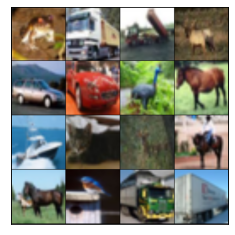

In [8]:
batch_X, batch_Y = iter(data_loader_test).next()
show_images(batch_X, 16)
print('\n'.join(list(map(lambda x: label_names[x], batch_Y[:16]))))

In [9]:
print(f"Input Shape: {batch_X[0].shape}")

Input Shape: torch.Size([3, 224, 224])


### Model

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

In [11]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1_pool):
        super(InceptionBlock, self).__init__()

        self.branch1x1 = ConvBlock(in_channels, out_1x1, kernel_size=1)
        self.branch3x3 = nn.Sequential(
            ConvBlock(in_channels, red_3x3, kernel_size=1),
            ConvBlock(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        self.branch5x5 = nn.Sequential(
            ConvBlock(in_channels, red_5x5, kernel_size=1),
            ConvBlock(red_5x5, out_5x5, kernel_size=5, padding=2)
        )
        self.branch_max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_1x1_pool, kernel_size=1)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1x1(x), self.branch3x3(x),
            self.branch5x5(x), self.branch_max_pool(x)
        ], 1)

In [12]:
class InceptionNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(InceptionNet, self).__init__()

        self.conv1 = ConvBlock(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)

        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)

        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)

        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)

        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

In [13]:
model = InceptionNet().to(device)
summary(model, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         ConvBlock-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
       BatchNorm2d-7          [-1, 192, 56, 56]             384
              ReLU-8          [-1, 192, 56, 56]               0
         ConvBlock-9          [-1, 192, 56, 56]               0
        MaxPool2d-10          [-1, 192, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          12,352
      BatchNorm2d-12           [-1, 64, 28, 28]             128
             ReLU-13           [-1, 64, 28, 28]               0
        ConvBlock-14           [-1, 64,

# Training

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [15]:
for epoch in range(2):
    print(f'Starting Epoch {epoch}')

    for batch_i, (X, Y) in enumerate(data_loader_train):
        X = X.to(device)
        Y = F.one_hot(Y, num_classes=10).float().to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if batch_i % 10 == 0:
            print(f"Training Loss: {loss.item()}")

Starting Epoch 0
Training Loss: 2.287696123123169
Training Loss: 2.6661581993103027
Training Loss: 2.5623457431793213
Training Loss: 2.2676379680633545
Training Loss: 2.384791612625122
Training Loss: 2.375342845916748
Training Loss: 2.3898746967315674
Training Loss: 2.163234233856201
Training Loss: 2.4443249702453613
Training Loss: 2.1754446029663086
Training Loss: 2.13430118560791
Training Loss: 2.0388762950897217
Training Loss: 2.0567545890808105
Training Loss: 2.0655131340026855
Training Loss: 2.1464760303497314
Training Loss: 2.179926872253418
Training Loss: 2.0527796745300293
Training Loss: 2.1640465259552
Training Loss: 1.9873679876327515
Training Loss: 1.938377022743225
Training Loss: 2.003504753112793
Training Loss: 1.8533589839935303
Training Loss: 1.6706409454345703
Training Loss: 1.915592074394226
Training Loss: 1.9069105386734009
Training Loss: 1.9755569696426392
Training Loss: 1.9467263221740723
Training Loss: 1.7754344940185547
Training Loss: 2.083488702774048
Training Lo

## Evaluation

Accuracy: 0.669219970703125


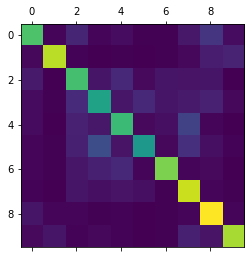

In [16]:
correct = 0
total = 0
confusion_matrix = [[0 for _ in range(10)] for _ in range(10)]

with torch.no_grad():
    for batch_i, (X, Y) in enumerate(data_loader_test):
        total += X.shape[0]
        
        X = X.to(device)
        Y = Y.to(device)
        outputs = torch.argmax(model(X), dim=1)
        correct += torch.sum(outputs == Y)

        for true, pred in zip(Y, outputs):
            confusion_matrix[true][pred] += 1
    
print(f"Accuracy: {correct / total}")
plt.matshow(confusion_matrix)